In [1]:
import os, time, math, csv, joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
pd.options.display.float_format = '{:.2f}'.format

In [2]:
data_path=os.getcwd()+"/ANN_dataset/rawData/rawData_mod"
output_data_path=os.getcwd()+"/ANN_dataset/trainingData"
model_path=os.getcwd()+"/models"
distances=list(range(1,26))
print(distances)
trainingProp=0.80
ns=50 # number of samples
centers=[[-3,3],[-1,3],[1,3],[3,3],[-3,1],[-1,1],[1,1],[3,1],[-3,-1],[-1,-1],[1,-1],[3,-1],[-3,-3],[-1,-3],[1,-3],[3,-3]]
selCP=[1,7,10,15]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [3]:
def L2dist(a,b):
    return math.sqrt(math.pow(a[0]-b[0],2)+math.pow(a[1]-b[1],2))

In [4]:
F=[]
for ll in distances:
    filename=data_path+"/consts_"+str(ll)+"span_mod.csv"
    df = pd.read_csv(filename)
    print(ll)
    for i in range(1,ns+1):
        df_aux=df[df["Sample_Id"]==i]
        real=df_aux["Real"]
        imag=df_aux["Imag"]
        data_aux=list(zip(real,imag))
        gmm = GaussianMixture(n_components=16, random_state=0, init_params='kmeans', means_init=centers).fit(data_aux)
        mus=gmm.means_
        sigmas=gmm.covariances_
        features=[ll*80]
        for jj in selCP:
            j=centers[jj-1]
            mindist=None
            k_inc=None
            for k in range(16):
                d=L2dist(mus[k],j)
                if mindist is None or mindist>d:
                    mindist=d
                    k_inc=k
            covmat=np.concatenate(list(sigmas[k_inc])).ravel().tolist()
            features = [*features, *mus[k_inc], *covmat]
        F.append(features)   

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


In [5]:
R=np.random.permutation(len(F))
nt=math.ceil(len(F)*trainingProp)
rows_training=R[0:nt]
rows_testing=R[(nt):(len(F)+1)]

In [6]:
header=['dist']
for j in selCP:
    header=[*header,*['mu_r_'+str(j),'mu_i_'+str(j),'sigma_rr_'+str(j),'sigma_ri_'+str(j),'sigma_ir_'+str(j),'sigma_ii_'+str(j)]]
    
F_training=[F[f] for f in rows_training]
F_testing=[F[f] for f in rows_testing]

DF_training=pd.DataFrame(F_training)
DF_training.columns=header
DF_training.to_csv(output_data_path+'/training_data_DNN.csv', index=False)

DF_testing=pd.DataFrame(F_testing)
DF_testing.columns=header
DF_testing.to_csv(output_data_path+'/testing_data_DNN.csv', index=False)

In [7]:

df=pd.read_csv(output_data_path+'/training_data_DNN.csv')

colnames=df.columns[1:25]
# Target variable and train set
X=df.iloc[:,1:25]
#print(X.shape)
#print(X.columns)
Y=df.iloc[:,0].to_numpy().reshape(-1,1)
#print(Y.shape)
#print(Y.columns)

#labels=[int(i) for i in df.iloc[:,0]]

sc_input = MinMaxScaler()
sc_output = MinMaxScaler()
X_train = sc_input.fit_transform(X)
Y_train = sc_output.fit_transform(Y)


In [8]:
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping


def ann():
    model = Sequential()
    model.add(Dense(24, input_dim = 24, activation = 'tanh'))
    model.add(Dense(12,activation='tanh'))
    model.add(Dense(6,activation='tanh'))
    model.add(Dense(1))
    model.compile(loss ='mean_squared_error',optimizer = 'RMSprop')
    return model


model_ann = KerasRegressor(build_fn=ann,epochs=5000,batch_size=32)

start_time = time.time()
callback = EarlyStopping(monitor='loss', patience=500)
model_ann.fit(X_train, Y_train, callbacks=[callback])
time_train_ann = time.time() - start_time

Epoch 1/5000
32/32 [==============================] - 9s 526us/step - loss: 0.0356
Epoch 2/5000
32/32 [==============================] - 0s 524us/step - loss: 0.0055
Epoch 3/5000
32/32 [==============================] - 0s 508us/step - loss: 0.0047
Epoch 4/5000
32/32 [==============================] - 0s 503us/step - loss: 0.0033
Epoch 5/5000
32/32 [==============================] - 0s 541us/step - loss: 0.0029
Epoch 6/5000
32/32 [==============================] - 0s 548us/step - loss: 0.0028
Epoch 7/5000
32/32 [==============================] - 0s 556us/step - loss: 0.0019
Epoch 8/5000
32/32 [==============================] - 0s 504us/step - loss: 0.0016
Epoch 9/5000
32/32 [==============================] - 0s 494us/step - loss: 0.0014
Epoch 10/5000
32/32 [==============================] - 0s 494us/step - loss: 0.0017
Epoch 11/5000
32/32 [==============================] - 0s 490us/step - loss: 0.0014
Epoch 12/5000
32/32 [==============================] - 0s 491us/step - loss: 0.0018
E

32/32 [==============================] - 0s 517us/step - loss: 4.7712e-04
Epoch 96/5000
32/32 [==============================] - 0s 516us/step - loss: 5.5312e-04
Epoch 97/5000
32/32 [==============================] - 0s 521us/step - loss: 3.6014e-04
Epoch 98/5000
32/32 [==============================] - 0s 521us/step - loss: 4.3673e-04
Epoch 99/5000
32/32 [==============================] - 0s 497us/step - loss: 4.0551e-04
Epoch 100/5000
32/32 [==============================] - 0s 523us/step - loss: 3.1956e-04
Epoch 101/5000
32/32 [==============================] - 0s 540us/step - loss: 3.8976e-04
Epoch 102/5000
32/32 [==============================] - 0s 521us/step - loss: 4.8015e-04
Epoch 103/5000
32/32 [==============================] - 0s 508us/step - loss: 3.8295e-04
Epoch 104/5000
32/32 [==============================] - 0s 531us/step - loss: 3.3493e-04
Epoch 105/5000
32/32 [==============================] - 0s 555us/step - loss: 4.2752e-04
Epoch 106/5000
32/32 [==================

32/32 [==============================] - 0s 506us/step - loss: 3.3304e-04
Epoch 188/5000
32/32 [==============================] - 0s 543us/step - loss: 4.1004e-04
Epoch 189/5000
32/32 [==============================] - 0s 481us/step - loss: 2.7649e-04
Epoch 190/5000
32/32 [==============================] - 0s 551us/step - loss: 3.5743e-04
Epoch 191/5000
32/32 [==============================] - 0s 504us/step - loss: 3.1696e-04
Epoch 192/5000
32/32 [==============================] - 0s 516us/step - loss: 4.0789e-04
Epoch 193/5000
32/32 [==============================] - 0s 523us/step - loss: 2.9559e-04
Epoch 194/5000
32/32 [==============================] - 0s 518us/step - loss: 3.9195e-04
Epoch 195/5000
32/32 [==============================] - 0s 525us/step - loss: 3.6066e-04
Epoch 196/5000
32/32 [==============================] - 0s 491us/step - loss: 3.0515e-04
Epoch 197/5000
32/32 [==============================] - 0s 481us/step - loss: 3.3566e-04
Epoch 198/5000
32/32 [==============

32/32 [==============================] - 0s 550us/step - loss: 2.2109e-04
Epoch 280/5000
32/32 [==============================] - 0s 529us/step - loss: 3.3323e-04
Epoch 281/5000
32/32 [==============================] - 0s 537us/step - loss: 2.5929e-04
Epoch 282/5000
32/32 [==============================] - 0s 515us/step - loss: 1.9214e-04
Epoch 283/5000
32/32 [==============================] - 0s 531us/step - loss: 2.2686e-04
Epoch 284/5000
32/32 [==============================] - 0s 509us/step - loss: 2.3907e-04
Epoch 285/5000
32/32 [==============================] - 0s 518us/step - loss: 2.3675e-04
Epoch 286/5000
32/32 [==============================] - 0s 491us/step - loss: 3.1242e-04
Epoch 287/5000
32/32 [==============================] - 0s 507us/step - loss: 1.8895e-04
Epoch 288/5000
32/32 [==============================] - 0s 496us/step - loss: 2.1845e-04
Epoch 289/5000
32/32 [==============================] - 0s 527us/step - loss: 2.3633e-04
Epoch 290/5000
32/32 [==============

32/32 [==============================] - 0s 499us/step - loss: 2.3198e-04
Epoch 372/5000
32/32 [==============================] - 0s 509us/step - loss: 2.4293e-04
Epoch 373/5000
32/32 [==============================] - 0s 526us/step - loss: 1.9468e-04
Epoch 374/5000
32/32 [==============================] - 0s 515us/step - loss: 2.2515e-04
Epoch 375/5000
32/32 [==============================] - 0s 520us/step - loss: 2.1829e-04
Epoch 376/5000
32/32 [==============================] - 0s 506us/step - loss: 2.2779e-04
Epoch 377/5000
32/32 [==============================] - 0s 497us/step - loss: 2.2250e-04
Epoch 378/5000
32/32 [==============================] - 0s 489us/step - loss: 2.8373e-04
Epoch 379/5000
32/32 [==============================] - 0s 537us/step - loss: 1.5632e-04
Epoch 380/5000
32/32 [==============================] - 0s 518us/step - loss: 1.9969e-04
Epoch 381/5000
32/32 [==============================] - 0s 516us/step - loss: 2.0348e-04
Epoch 382/5000
32/32 [==============

32/32 [==============================] - 0s 516us/step - loss: 2.8316e-04
Epoch 464/5000
32/32 [==============================] - 0s 501us/step - loss: 1.9718e-04
Epoch 465/5000
32/32 [==============================] - 0s 500us/step - loss: 1.7970e-04
Epoch 466/5000
32/32 [==============================] - 0s 522us/step - loss: 2.2128e-04
Epoch 467/5000
32/32 [==============================] - 0s 547us/step - loss: 2.1500e-04
Epoch 468/5000
32/32 [==============================] - 0s 522us/step - loss: 1.9785e-04
Epoch 469/5000
32/32 [==============================] - 0s 504us/step - loss: 2.0657e-04
Epoch 470/5000
32/32 [==============================] - 0s 480us/step - loss: 1.8404e-04
Epoch 471/5000
32/32 [==============================] - 0s 526us/step - loss: 1.9109e-04
Epoch 472/5000
32/32 [==============================] - 0s 530us/step - loss: 2.6206e-04
Epoch 473/5000
32/32 [==============================] - 0s 502us/step - loss: 2.1273e-04
Epoch 474/5000
32/32 [==============

32/32 [==============================] - 0s 516us/step - loss: 2.1427e-04
Epoch 556/5000
32/32 [==============================] - 0s 477us/step - loss: 1.4560e-04
Epoch 557/5000
32/32 [==============================] - 0s 487us/step - loss: 2.0223e-04
Epoch 558/5000
32/32 [==============================] - 0s 497us/step - loss: 1.5283e-04
Epoch 559/5000
32/32 [==============================] - 0s 506us/step - loss: 1.6324e-04
Epoch 560/5000
32/32 [==============================] - 0s 480us/step - loss: 1.8461e-04
Epoch 561/5000
32/32 [==============================] - 0s 491us/step - loss: 2.1428e-04
Epoch 562/5000
32/32 [==============================] - 0s 502us/step - loss: 1.7360e-04
Epoch 563/5000
32/32 [==============================] - 0s 524us/step - loss: 2.1019e-04
Epoch 564/5000
32/32 [==============================] - 0s 532us/step - loss: 1.5644e-04
Epoch 565/5000
32/32 [==============================] - 0s 498us/step - loss: 1.6499e-04
Epoch 566/5000
32/32 [==============

32/32 [==============================] - 0s 519us/step - loss: 1.6583e-04
Epoch 647/5000
32/32 [==============================] - 0s 496us/step - loss: 1.5801e-04
Epoch 648/5000
32/32 [==============================] - 0s 517us/step - loss: 1.6344e-04
Epoch 649/5000
32/32 [==============================] - 0s 513us/step - loss: 1.8959e-04
Epoch 650/5000
32/32 [==============================] - 0s 496us/step - loss: 1.6520e-04
Epoch 651/5000
32/32 [==============================] - 0s 536us/step - loss: 1.8854e-04
Epoch 652/5000
32/32 [==============================] - 0s 515us/step - loss: 1.5491e-04
Epoch 653/5000
32/32 [==============================] - 0s 504us/step - loss: 2.1333e-04
Epoch 654/5000
32/32 [==============================] - 0s 499us/step - loss: 1.9950e-04
Epoch 655/5000
32/32 [==============================] - 0s 510us/step - loss: 1.8122e-04
Epoch 656/5000
32/32 [==============================] - 0s 517us/step - loss: 1.7502e-04
Epoch 657/5000
32/32 [==============

32/32 [==============================] - 0s 492us/step - loss: 1.6798e-04
Epoch 739/5000
32/32 [==============================] - 0s 523us/step - loss: 1.5822e-04
Epoch 740/5000
32/32 [==============================] - 0s 481us/step - loss: 1.3711e-04
Epoch 741/5000
32/32 [==============================] - 0s 494us/step - loss: 1.6024e-04
Epoch 742/5000
32/32 [==============================] - 0s 492us/step - loss: 1.3691e-04
Epoch 743/5000
32/32 [==============================] - 0s 522us/step - loss: 1.6822e-04
Epoch 744/5000
32/32 [==============================] - 0s 492us/step - loss: 1.7537e-04
Epoch 745/5000
32/32 [==============================] - 0s 511us/step - loss: 2.0019e-04
Epoch 746/5000
32/32 [==============================] - 0s 502us/step - loss: 1.6383e-04
Epoch 747/5000
32/32 [==============================] - 0s 517us/step - loss: 1.5234e-04
Epoch 748/5000
32/32 [==============================] - 0s 492us/step - loss: 1.9680e-04
Epoch 749/5000
32/32 [==============

32/32 [==============================] - 0s 539us/step - loss: 1.4778e-04
Epoch 831/5000
32/32 [==============================] - 0s 496us/step - loss: 1.5703e-04
Epoch 832/5000
32/32 [==============================] - 0s 499us/step - loss: 2.0737e-04
Epoch 833/5000
32/32 [==============================] - 0s 504us/step - loss: 1.4913e-04
Epoch 834/5000
32/32 [==============================] - 0s 500us/step - loss: 1.4464e-04
Epoch 835/5000
32/32 [==============================] - 0s 510us/step - loss: 1.5210e-04
Epoch 836/5000
32/32 [==============================] - 0s 525us/step - loss: 1.7969e-04
Epoch 837/5000
32/32 [==============================] - 0s 497us/step - loss: 1.7319e-04
Epoch 838/5000
32/32 [==============================] - 0s 511us/step - loss: 1.3971e-04
Epoch 839/5000
32/32 [==============================] - 0s 508us/step - loss: 1.7772e-04
Epoch 840/5000
32/32 [==============================] - 0s 509us/step - loss: 1.5098e-04
Epoch 841/5000
32/32 [==============

32/32 [==============================] - 0s 533us/step - loss: 1.6510e-04
Epoch 923/5000
32/32 [==============================] - 0s 531us/step - loss: 1.7396e-04
Epoch 924/5000
32/32 [==============================] - 0s 520us/step - loss: 1.4736e-04
Epoch 925/5000
32/32 [==============================] - 0s 520us/step - loss: 1.6806e-04
Epoch 926/5000
32/32 [==============================] - 0s 500us/step - loss: 1.5882e-04
Epoch 927/5000
32/32 [==============================] - 0s 519us/step - loss: 1.4644e-04
Epoch 928/5000
32/32 [==============================] - 0s 478us/step - loss: 1.3219e-04
Epoch 929/5000
32/32 [==============================] - 0s 508us/step - loss: 1.3225e-04
Epoch 930/5000
32/32 [==============================] - 0s 508us/step - loss: 1.5161e-04
Epoch 931/5000
32/32 [==============================] - 0s 501us/step - loss: 1.5307e-04
Epoch 932/5000
32/32 [==============================] - 0s 512us/step - loss: 1.6877e-04
Epoch 933/5000
32/32 [==============

32/32 [==============================] - 0s 514us/step - loss: 1.3502e-04
Epoch 1015/5000
32/32 [==============================] - 0s 494us/step - loss: 1.4056e-04
Epoch 1016/5000
32/32 [==============================] - 0s 513us/step - loss: 1.2914e-04
Epoch 1017/5000
32/32 [==============================] - 0s 565us/step - loss: 9.3419e-05
Epoch 1018/5000
32/32 [==============================] - 0s 515us/step - loss: 1.2434e-04
Epoch 1019/5000
32/32 [==============================] - 0s 474us/step - loss: 1.4748e-04
Epoch 1020/5000
32/32 [==============================] - 0s 494us/step - loss: 1.2673e-04
Epoch 1021/5000
32/32 [==============================] - 0s 499us/step - loss: 1.3600e-04
Epoch 1022/5000
32/32 [==============================] - 0s 539us/step - loss: 1.4360e-04
Epoch 1023/5000
32/32 [==============================] - 0s 526us/step - loss: 1.2358e-04
Epoch 1024/5000
32/32 [==============================] - 0s 505us/step - loss: 1.7939e-04
Epoch 1025/5000
32/32 [===

32/32 [==============================] - 0s 485us/step - loss: 1.3718e-04
Epoch 1106/5000
32/32 [==============================] - 0s 506us/step - loss: 1.0186e-04
Epoch 1107/5000
32/32 [==============================] - 0s 511us/step - loss: 1.4548e-04
Epoch 1108/5000
32/32 [==============================] - 0s 506us/step - loss: 1.5713e-04
Epoch 1109/5000
32/32 [==============================] - 0s 531us/step - loss: 1.2011e-04
Epoch 1110/5000
32/32 [==============================] - 0s 520us/step - loss: 1.1431e-04
Epoch 1111/5000
32/32 [==============================] - 0s 506us/step - loss: 1.0805e-04
Epoch 1112/5000
32/32 [==============================] - 0s 476us/step - loss: 1.3583e-04
Epoch 1113/5000
32/32 [==============================] - 0s 528us/step - loss: 1.1786e-04
Epoch 1114/5000
32/32 [==============================] - 0s 513us/step - loss: 1.6068e-04
Epoch 1115/5000
32/32 [==============================] - 0s 519us/step - loss: 1.7134e-04
Epoch 1116/5000
32/32 [===

32/32 [==============================] - 0s 578us/step - loss: 1.1644e-04
Epoch 1197/5000
32/32 [==============================] - 0s 537us/step - loss: 1.0944e-04
Epoch 1198/5000
32/32 [==============================] - 0s 499us/step - loss: 1.1684e-04
Epoch 1199/5000
32/32 [==============================] - 0s 511us/step - loss: 1.4597e-04
Epoch 1200/5000
32/32 [==============================] - 0s 521us/step - loss: 1.3379e-04
Epoch 1201/5000
32/32 [==============================] - 0s 550us/step - loss: 1.1043e-04
Epoch 1202/5000
32/32 [==============================] - 0s 515us/step - loss: 1.4787e-04
Epoch 1203/5000
32/32 [==============================] - 0s 494us/step - loss: 1.2252e-04
Epoch 1204/5000
32/32 [==============================] - 0s 538us/step - loss: 9.2915e-05
Epoch 1205/5000
32/32 [==============================] - 0s 507us/step - loss: 1.4153e-04
Epoch 1206/5000
32/32 [==============================] - 0s 514us/step - loss: 1.0817e-04
Epoch 1207/5000
32/32 [===

32/32 [==============================] - 0s 504us/step - loss: 1.0704e-04
Epoch 1288/5000
32/32 [==============================] - 0s 549us/step - loss: 1.1911e-04
Epoch 1289/5000
32/32 [==============================] - 0s 494us/step - loss: 9.7789e-05
Epoch 1290/5000
32/32 [==============================] - 0s 526us/step - loss: 1.5850e-04
Epoch 1291/5000
32/32 [==============================] - 0s 510us/step - loss: 9.6329e-05
Epoch 1292/5000
32/32 [==============================] - 0s 517us/step - loss: 7.4582e-05
Epoch 1293/5000
32/32 [==============================] - 0s 526us/step - loss: 1.1980e-04
Epoch 1294/5000
32/32 [==============================] - 0s 495us/step - loss: 1.0894e-04
Epoch 1295/5000
32/32 [==============================] - 0s 535us/step - loss: 1.0855e-04
Epoch 1296/5000
32/32 [==============================] - 0s 538us/step - loss: 1.5416e-04
Epoch 1297/5000
32/32 [==============================] - 0s 541us/step - loss: 1.0015e-04
Epoch 1298/5000
32/32 [===

32/32 [==============================] - 0s 503us/step - loss: 1.0257e-04
Epoch 1379/5000
32/32 [==============================] - 0s 521us/step - loss: 1.5553e-04
Epoch 1380/5000
32/32 [==============================] - 0s 494us/step - loss: 1.0913e-04
Epoch 1381/5000
32/32 [==============================] - 0s 510us/step - loss: 1.4766e-04
Epoch 1382/5000
32/32 [==============================] - 0s 510us/step - loss: 1.0272e-04
Epoch 1383/5000
32/32 [==============================] - 0s 499us/step - loss: 9.3861e-05
Epoch 1384/5000
32/32 [==============================] - 0s 504us/step - loss: 1.0433e-04
Epoch 1385/5000
32/32 [==============================] - 0s 515us/step - loss: 1.1255e-04
Epoch 1386/5000
32/32 [==============================] - 0s 485us/step - loss: 1.1574e-04
Epoch 1387/5000
32/32 [==============================] - 0s 523us/step - loss: 9.9791e-05
Epoch 1388/5000
32/32 [==============================] - 0s 508us/step - loss: 1.0743e-04
Epoch 1389/5000
32/32 [===

32/32 [==============================] - 0s 511us/step - loss: 1.1879e-04
Epoch 1470/5000
32/32 [==============================] - 0s 500us/step - loss: 1.1616e-04
Epoch 1471/5000
32/32 [==============================] - 0s 528us/step - loss: 1.3482e-04
Epoch 1472/5000
32/32 [==============================] - 0s 501us/step - loss: 9.4961e-05
Epoch 1473/5000
32/32 [==============================] - 0s 513us/step - loss: 1.0866e-04
Epoch 1474/5000
32/32 [==============================] - 0s 535us/step - loss: 1.2925e-04
Epoch 1475/5000
32/32 [==============================] - 0s 480us/step - loss: 1.0049e-04
Epoch 1476/5000
32/32 [==============================] - 0s 506us/step - loss: 9.3951e-05
Epoch 1477/5000
32/32 [==============================] - 0s 524us/step - loss: 1.1657e-04
Epoch 1478/5000
32/32 [==============================] - 0s 510us/step - loss: 8.6957e-05
Epoch 1479/5000
32/32 [==============================] - 0s 514us/step - loss: 1.1022e-04
Epoch 1480/5000
32/32 [===

32/32 [==============================] - 0s 503us/step - loss: 1.0364e-04
Epoch 1561/5000
32/32 [==============================] - 0s 502us/step - loss: 9.9135e-05
Epoch 1562/5000
32/32 [==============================] - 0s 557us/step - loss: 1.1223e-04
Epoch 1563/5000
32/32 [==============================] - 0s 517us/step - loss: 1.1264e-04
Epoch 1564/5000
32/32 [==============================] - 0s 511us/step - loss: 9.3534e-05
Epoch 1565/5000
32/32 [==============================] - 0s 521us/step - loss: 9.1350e-05
Epoch 1566/5000
32/32 [==============================] - 0s 489us/step - loss: 9.5623e-05
Epoch 1567/5000
32/32 [==============================] - 0s 540us/step - loss: 7.6649e-05
Epoch 1568/5000
32/32 [==============================] - 0s 486us/step - loss: 8.3251e-05
Epoch 1569/5000
32/32 [==============================] - 0s 493us/step - loss: 1.2144e-04
Epoch 1570/5000
32/32 [==============================] - 0s 551us/step - loss: 9.3097e-05
Epoch 1571/5000
32/32 [===

32/32 [==============================] - 0s 505us/step - loss: 9.9726e-05
Epoch 1652/5000
32/32 [==============================] - 0s 497us/step - loss: 1.0304e-04
Epoch 1653/5000
32/32 [==============================] - 0s 523us/step - loss: 1.0256e-04
Epoch 1654/5000
32/32 [==============================] - 0s 497us/step - loss: 9.5179e-05
Epoch 1655/5000
32/32 [==============================] - 0s 515us/step - loss: 1.0313e-04
Epoch 1656/5000
32/32 [==============================] - 0s 528us/step - loss: 8.9258e-05
Epoch 1657/5000
32/32 [==============================] - 0s 499us/step - loss: 8.0521e-05
Epoch 1658/5000
32/32 [==============================] - 0s 496us/step - loss: 1.3407e-04
Epoch 1659/5000
32/32 [==============================] - 0s 531us/step - loss: 1.0147e-04
Epoch 1660/5000
32/32 [==============================] - 0s 498us/step - loss: 9.6567e-05
Epoch 1661/5000
32/32 [==============================] - 0s 521us/step - loss: 8.8128e-05
Epoch 1662/5000
32/32 [===

32/32 [==============================] - 0s 522us/step - loss: 1.2752e-04
Epoch 1743/5000
32/32 [==============================] - 0s 525us/step - loss: 1.0374e-04
Epoch 1744/5000
32/32 [==============================] - 0s 498us/step - loss: 9.0700e-05
Epoch 1745/5000
32/32 [==============================] - 0s 562us/step - loss: 1.0099e-04
Epoch 1746/5000
32/32 [==============================] - 0s 499us/step - loss: 9.5475e-05
Epoch 1747/5000
32/32 [==============================] - 0s 497us/step - loss: 9.9559e-05
Epoch 1748/5000
32/32 [==============================] - 0s 484us/step - loss: 9.2857e-05
Epoch 1749/5000
32/32 [==============================] - 0s 494us/step - loss: 1.0143e-04
Epoch 1750/5000
32/32 [==============================] - 0s 482us/step - loss: 1.1160e-04
Epoch 1751/5000
32/32 [==============================] - 0s 505us/step - loss: 8.8978e-05
Epoch 1752/5000
32/32 [==============================] - 0s 518us/step - loss: 1.0615e-04
Epoch 1753/5000
32/32 [===

32/32 [==============================] - 0s 499us/step - loss: 8.7955e-05
Epoch 1834/5000
32/32 [==============================] - 0s 496us/step - loss: 8.6765e-05
Epoch 1835/5000
32/32 [==============================] - 0s 510us/step - loss: 8.3192e-05
Epoch 1836/5000
32/32 [==============================] - 0s 524us/step - loss: 1.0867e-04
Epoch 1837/5000
32/32 [==============================] - 0s 520us/step - loss: 1.0089e-04
Epoch 1838/5000
32/32 [==============================] - 0s 533us/step - loss: 9.4488e-05
Epoch 1839/5000
32/32 [==============================] - 0s 520us/step - loss: 1.0465e-04
Epoch 1840/5000
32/32 [==============================] - 0s 505us/step - loss: 9.3185e-05
Epoch 1841/5000
32/32 [==============================] - 0s 494us/step - loss: 7.9357e-05
Epoch 1842/5000
32/32 [==============================] - 0s 505us/step - loss: 9.3944e-05
Epoch 1843/5000
32/32 [==============================] - 0s 496us/step - loss: 9.6029e-05
Epoch 1844/5000
32/32 [===

32/32 [==============================] - 0s 530us/step - loss: 9.6914e-05
Epoch 1925/5000
32/32 [==============================] - 0s 506us/step - loss: 1.0097e-04
Epoch 1926/5000
32/32 [==============================] - 0s 487us/step - loss: 8.1634e-05
Epoch 1927/5000
32/32 [==============================] - 0s 506us/step - loss: 1.1427e-04
Epoch 1928/5000
32/32 [==============================] - 0s 502us/step - loss: 8.4035e-05
Epoch 1929/5000
32/32 [==============================] - 0s 518us/step - loss: 1.0162e-04
Epoch 1930/5000
32/32 [==============================] - 0s 501us/step - loss: 1.0078e-04
Epoch 1931/5000
32/32 [==============================] - 0s 488us/step - loss: 9.4763e-05
Epoch 1932/5000
32/32 [==============================] - 0s 519us/step - loss: 8.6773e-05
Epoch 1933/5000
32/32 [==============================] - 0s 486us/step - loss: 9.4924e-05
Epoch 1934/5000
32/32 [==============================] - 0s 509us/step - loss: 8.1453e-05
Epoch 1935/5000
32/32 [===

32/32 [==============================] - 0s 491us/step - loss: 9.9604e-05
Epoch 2016/5000
32/32 [==============================] - 0s 517us/step - loss: 7.7201e-05
Epoch 2017/5000
32/32 [==============================] - 0s 487us/step - loss: 6.6672e-05
Epoch 2018/5000
32/32 [==============================] - 0s 506us/step - loss: 1.0574e-04
Epoch 2019/5000
32/32 [==============================] - 0s 487us/step - loss: 9.0857e-05
Epoch 2020/5000
32/32 [==============================] - 0s 516us/step - loss: 7.9072e-05
Epoch 2021/5000
32/32 [==============================] - 0s 519us/step - loss: 8.9754e-05
Epoch 2022/5000
32/32 [==============================] - 0s 524us/step - loss: 8.8172e-05
Epoch 2023/5000
32/32 [==============================] - 0s 554us/step - loss: 8.6791e-05
Epoch 2024/5000
32/32 [==============================] - 0s 529us/step - loss: 9.4343e-05
Epoch 2025/5000
32/32 [==============================] - 0s 497us/step - loss: 7.7833e-05
Epoch 2026/5000
32/32 [===

32/32 [==============================] - 0s 511us/step - loss: 9.5608e-05
Epoch 2107/5000
32/32 [==============================] - 0s 521us/step - loss: 8.2780e-05
Epoch 2108/5000
32/32 [==============================] - 0s 505us/step - loss: 8.7398e-05
Epoch 2109/5000
32/32 [==============================] - 0s 517us/step - loss: 6.9356e-05
Epoch 2110/5000
32/32 [==============================] - 0s 543us/step - loss: 1.0537e-04
Epoch 2111/5000
32/32 [==============================] - 0s 515us/step - loss: 7.7097e-05
Epoch 2112/5000
32/32 [==============================] - 0s 518us/step - loss: 8.2720e-05
Epoch 2113/5000
32/32 [==============================] - 0s 512us/step - loss: 8.1598e-05
Epoch 2114/5000
32/32 [==============================] - 0s 518us/step - loss: 7.5702e-05
Epoch 2115/5000
32/32 [==============================] - 0s 508us/step - loss: 8.6513e-05
Epoch 2116/5000
32/32 [==============================] - 0s 508us/step - loss: 7.2869e-05
Epoch 2117/5000
32/32 [===

32/32 [==============================] - 0s 498us/step - loss: 7.6145e-05
Epoch 2198/5000
32/32 [==============================] - 0s 526us/step - loss: 8.3305e-05
Epoch 2199/5000
32/32 [==============================] - 0s 503us/step - loss: 6.9651e-05
Epoch 2200/5000
32/32 [==============================] - 0s 497us/step - loss: 1.0566e-04
Epoch 2201/5000
32/32 [==============================] - 0s 503us/step - loss: 8.4580e-05
Epoch 2202/5000
32/32 [==============================] - 0s 506us/step - loss: 8.3981e-05
Epoch 2203/5000
32/32 [==============================] - 0s 522us/step - loss: 8.2295e-05
Epoch 2204/5000
32/32 [==============================] - 0s 524us/step - loss: 8.0597e-05
Epoch 2205/5000
32/32 [==============================] - 0s 507us/step - loss: 6.5304e-05
Epoch 2206/5000
32/32 [==============================] - 0s 569us/step - loss: 9.8996e-05
Epoch 2207/5000
32/32 [==============================] - 0s 518us/step - loss: 9.2389e-05
Epoch 2208/5000
32/32 [===

32/32 [==============================] - 0s 519us/step - loss: 7.8518e-05
Epoch 2289/5000
32/32 [==============================] - 0s 523us/step - loss: 8.9395e-05
Epoch 2290/5000
32/32 [==============================] - 0s 502us/step - loss: 1.0644e-04
Epoch 2291/5000
32/32 [==============================] - 0s 629us/step - loss: 7.1534e-05
Epoch 2292/5000
32/32 [==============================] - 0s 519us/step - loss: 8.1900e-05
Epoch 2293/5000
32/32 [==============================] - 0s 493us/step - loss: 8.6283e-05
Epoch 2294/5000
32/32 [==============================] - 0s 492us/step - loss: 9.0370e-05
Epoch 2295/5000
32/32 [==============================] - 0s 526us/step - loss: 7.9245e-05
Epoch 2296/5000
32/32 [==============================] - 0s 547us/step - loss: 8.1130e-05
Epoch 2297/5000
32/32 [==============================] - 0s 510us/step - loss: 7.6722e-05
Epoch 2298/5000
32/32 [==============================] - 0s 546us/step - loss: 8.2786e-05
Epoch 2299/5000
32/32 [===

32/32 [==============================] - 0s 510us/step - loss: 7.5072e-05
Epoch 2380/5000
32/32 [==============================] - 0s 522us/step - loss: 9.3742e-05
Epoch 2381/5000
32/32 [==============================] - 0s 491us/step - loss: 8.1712e-05
Epoch 2382/5000
32/32 [==============================] - 0s 532us/step - loss: 7.9493e-05
Epoch 2383/5000
32/32 [==============================] - 0s 536us/step - loss: 8.8390e-05
Epoch 2384/5000
32/32 [==============================] - 0s 520us/step - loss: 6.9715e-05
Epoch 2385/5000
32/32 [==============================] - 0s 513us/step - loss: 7.2338e-05
Epoch 2386/5000
32/32 [==============================] - 0s 499us/step - loss: 7.0832e-05
Epoch 2387/5000
32/32 [==============================] - 0s 493us/step - loss: 8.3829e-05
Epoch 2388/5000
32/32 [==============================] - 0s 518us/step - loss: 8.6813e-05
Epoch 2389/5000
32/32 [==============================] - 0s 537us/step - loss: 7.6118e-05
Epoch 2390/5000
32/32 [===

32/32 [==============================] - 0s 531us/step - loss: 7.5473e-05
Epoch 2471/5000
32/32 [==============================] - 0s 546us/step - loss: 7.3932e-05
Epoch 2472/5000
32/32 [==============================] - 0s 551us/step - loss: 8.0021e-05
Epoch 2473/5000
32/32 [==============================] - 0s 586us/step - loss: 7.2754e-05
Epoch 2474/5000
32/32 [==============================] - 0s 487us/step - loss: 8.9214e-05
Epoch 2475/5000
32/32 [==============================] - 0s 492us/step - loss: 7.4825e-05
Epoch 2476/5000
32/32 [==============================] - 0s 514us/step - loss: 7.1513e-05
Epoch 2477/5000
32/32 [==============================] - 0s 494us/step - loss: 8.9558e-05
Epoch 2478/5000
32/32 [==============================] - 0s 505us/step - loss: 7.3761e-05
Epoch 2479/5000
32/32 [==============================] - 0s 499us/step - loss: 7.6304e-05
Epoch 2480/5000
32/32 [==============================] - 0s 494us/step - loss: 8.3863e-05
Epoch 2481/5000
32/32 [===

32/32 [==============================] - 0s 491us/step - loss: 1.0092e-04
Epoch 2562/5000
32/32 [==============================] - 0s 499us/step - loss: 6.6852e-05
Epoch 2563/5000
32/32 [==============================] - 0s 534us/step - loss: 8.3626e-05
Epoch 2564/5000
32/32 [==============================] - 0s 514us/step - loss: 7.7534e-05
Epoch 2565/5000
32/32 [==============================] - 0s 540us/step - loss: 7.8179e-05
Epoch 2566/5000
32/32 [==============================] - 0s 514us/step - loss: 7.2246e-05
Epoch 2567/5000
32/32 [==============================] - 0s 492us/step - loss: 8.2306e-05
Epoch 2568/5000
32/32 [==============================] - 0s 534us/step - loss: 7.0723e-05
Epoch 2569/5000
32/32 [==============================] - 0s 514us/step - loss: 7.2922e-05
Epoch 2570/5000
32/32 [==============================] - 0s 500us/step - loss: 7.8863e-05
Epoch 2571/5000
32/32 [==============================] - 0s 519us/step - loss: 7.1377e-05
Epoch 2572/5000
32/32 [===

32/32 [==============================] - 0s 494us/step - loss: 7.3174e-05
Epoch 2653/5000
32/32 [==============================] - 0s 519us/step - loss: 7.4890e-05
Epoch 2654/5000
32/32 [==============================] - 0s 513us/step - loss: 7.6265e-05
Epoch 2655/5000
32/32 [==============================] - 0s 516us/step - loss: 7.4979e-05
Epoch 2656/5000
32/32 [==============================] - 0s 508us/step - loss: 7.7478e-05
Epoch 2657/5000
32/32 [==============================] - 0s 505us/step - loss: 7.9465e-05
Epoch 2658/5000
32/32 [==============================] - 0s 495us/step - loss: 7.8483e-05
Epoch 2659/5000
32/32 [==============================] - 0s 523us/step - loss: 7.7109e-05
Epoch 2660/5000
32/32 [==============================] - 0s 520us/step - loss: 7.1395e-05
Epoch 2661/5000
32/32 [==============================] - 0s 511us/step - loss: 6.2422e-05
Epoch 2662/5000
32/32 [==============================] - 0s 514us/step - loss: 7.3157e-05
Epoch 2663/5000
32/32 [===

32/32 [==============================] - 0s 484us/step - loss: 7.1751e-05
Epoch 2744/5000
32/32 [==============================] - 0s 487us/step - loss: 7.4135e-05
Epoch 2745/5000
32/32 [==============================] - 0s 480us/step - loss: 6.7717e-05
Epoch 2746/5000
32/32 [==============================] - 0s 490us/step - loss: 6.7006e-05
Epoch 2747/5000
32/32 [==============================] - 0s 472us/step - loss: 8.4392e-05
Epoch 2748/5000
32/32 [==============================] - 0s 488us/step - loss: 7.5629e-05
Epoch 2749/5000
32/32 [==============================] - 0s 501us/step - loss: 7.2484e-05
Epoch 2750/5000
32/32 [==============================] - 0s 490us/step - loss: 1.0186e-04
Epoch 2751/5000
32/32 [==============================] - 0s 505us/step - loss: 7.2247e-05
Epoch 2752/5000
32/32 [==============================] - 0s 504us/step - loss: 7.7482e-05
Epoch 2753/5000
32/32 [==============================] - 0s 517us/step - loss: 7.6312e-05
Epoch 2754/5000
32/32 [===

32/32 [==============================] - 0s 505us/step - loss: 6.3017e-05
Epoch 2835/5000
32/32 [==============================] - 0s 526us/step - loss: 8.1672e-05
Epoch 2836/5000
32/32 [==============================] - 0s 481us/step - loss: 7.4608e-05
Epoch 2837/5000
32/32 [==============================] - 0s 539us/step - loss: 7.8738e-05
Epoch 2838/5000
32/32 [==============================] - 0s 499us/step - loss: 6.9269e-05
Epoch 2839/5000
32/32 [==============================] - 0s 528us/step - loss: 6.5318e-05
Epoch 2840/5000
32/32 [==============================] - 0s 517us/step - loss: 7.3977e-05
Epoch 2841/5000
32/32 [==============================] - 0s 503us/step - loss: 7.8383e-05
Epoch 2842/5000
32/32 [==============================] - 0s 503us/step - loss: 8.5633e-05
Epoch 2843/5000
32/32 [==============================] - 0s 511us/step - loss: 7.2865e-05
Epoch 2844/5000
32/32 [==============================] - 0s 499us/step - loss: 8.1943e-05
Epoch 2845/5000
32/32 [===

32/32 [==============================] - 0s 496us/step - loss: 6.3676e-05
Epoch 2926/5000
32/32 [==============================] - 0s 494us/step - loss: 7.1873e-05
Epoch 2927/5000
32/32 [==============================] - 0s 530us/step - loss: 7.5134e-05
Epoch 2928/5000
32/32 [==============================] - 0s 532us/step - loss: 6.6616e-05
Epoch 2929/5000
32/32 [==============================] - 0s 519us/step - loss: 6.0632e-05
Epoch 2930/5000
32/32 [==============================] - 0s 527us/step - loss: 7.7467e-05
Epoch 2931/5000
32/32 [==============================] - 0s 517us/step - loss: 7.4764e-05
Epoch 2932/5000
32/32 [==============================] - 0s 521us/step - loss: 7.0439e-05
Epoch 2933/5000
32/32 [==============================] - 0s 492us/step - loss: 6.2902e-05
Epoch 2934/5000
32/32 [==============================] - 0s 525us/step - loss: 6.4705e-05
Epoch 2935/5000
32/32 [==============================] - 0s 520us/step - loss: 8.2053e-05
Epoch 2936/5000
32/32 [===

32/32 [==============================] - 0s 488us/step - loss: 7.3414e-05
Epoch 3017/5000
32/32 [==============================] - 0s 482us/step - loss: 8.0717e-05
Epoch 3018/5000
32/32 [==============================] - 0s 524us/step - loss: 8.0346e-05
Epoch 3019/5000
32/32 [==============================] - 0s 568us/step - loss: 7.5681e-05
Epoch 3020/5000
32/32 [==============================] - 0s 519us/step - loss: 7.4505e-05
Epoch 3021/5000
32/32 [==============================] - 0s 509us/step - loss: 6.4135e-05
Epoch 3022/5000
32/32 [==============================] - 0s 512us/step - loss: 7.5751e-05
Epoch 3023/5000
32/32 [==============================] - 0s 533us/step - loss: 6.9414e-05
Epoch 3024/5000
32/32 [==============================] - 0s 526us/step - loss: 8.1912e-05
Epoch 3025/5000
32/32 [==============================] - 0s 512us/step - loss: 8.2214e-05
Epoch 3026/5000
32/32 [==============================] - 0s 507us/step - loss: 5.5218e-05
Epoch 3027/5000
32/32 [===

32/32 [==============================] - 0s 519us/step - loss: 6.9717e-05
Epoch 3108/5000
32/32 [==============================] - 0s 530us/step - loss: 6.9174e-05
Epoch 3109/5000
32/32 [==============================] - 0s 521us/step - loss: 6.2428e-05
Epoch 3110/5000
32/32 [==============================] - 0s 530us/step - loss: 7.0553e-05
Epoch 3111/5000
32/32 [==============================] - 0s 525us/step - loss: 7.1790e-05
Epoch 3112/5000
32/32 [==============================] - 0s 509us/step - loss: 6.6416e-05
Epoch 3113/5000
32/32 [==============================] - 0s 491us/step - loss: 7.2171e-05
Epoch 3114/5000
32/32 [==============================] - 0s 517us/step - loss: 6.9750e-05
Epoch 3115/5000
32/32 [==============================] - 0s 554us/step - loss: 8.8550e-05
Epoch 3116/5000
32/32 [==============================] - 0s 508us/step - loss: 8.0690e-05
Epoch 3117/5000
32/32 [==============================] - 0s 524us/step - loss: 6.3498e-05
Epoch 3118/5000
32/32 [===

32/32 [==============================] - 0s 541us/step - loss: 6.7080e-05
Epoch 3199/5000
32/32 [==============================] - 0s 500us/step - loss: 6.5878e-05
Epoch 3200/5000
32/32 [==============================] - 0s 503us/step - loss: 8.5741e-05
Epoch 3201/5000
32/32 [==============================] - 0s 498us/step - loss: 7.3863e-05
Epoch 3202/5000
32/32 [==============================] - 0s 523us/step - loss: 7.6729e-05
Epoch 3203/5000
32/32 [==============================] - 0s 549us/step - loss: 6.8570e-05
Epoch 3204/5000
32/32 [==============================] - 0s 506us/step - loss: 6.6062e-05
Epoch 3205/5000
32/32 [==============================] - 0s 513us/step - loss: 7.1525e-05
Epoch 3206/5000
32/32 [==============================] - 0s 514us/step - loss: 7.8021e-05
Epoch 3207/5000
32/32 [==============================] - 0s 524us/step - loss: 7.0043e-05
Epoch 3208/5000
32/32 [==============================] - 0s 512us/step - loss: 8.7043e-05
Epoch 3209/5000
32/32 [===

32/32 [==============================] - 0s 517us/step - loss: 6.7747e-05
Epoch 3290/5000
32/32 [==============================] - 0s 509us/step - loss: 8.6107e-05
Epoch 3291/5000
32/32 [==============================] - 0s 529us/step - loss: 7.3829e-05
Epoch 3292/5000
32/32 [==============================] - 0s 532us/step - loss: 9.6500e-05
Epoch 3293/5000
32/32 [==============================] - 0s 517us/step - loss: 7.0471e-05
Epoch 3294/5000
32/32 [==============================] - 0s 495us/step - loss: 7.3719e-05
Epoch 3295/5000
32/32 [==============================] - 0s 505us/step - loss: 7.3709e-05
Epoch 3296/5000
32/32 [==============================] - 0s 518us/step - loss: 1.1449e-04
Epoch 3297/5000
32/32 [==============================] - 0s 519us/step - loss: 6.6019e-05
Epoch 3298/5000
32/32 [==============================] - 0s 497us/step - loss: 6.7056e-05
Epoch 3299/5000
32/32 [==============================] - 0s 524us/step - loss: 6.7699e-05
Epoch 3300/5000
32/32 [===

32/32 [==============================] - 0s 521us/step - loss: 6.7309e-05
Epoch 3381/5000
32/32 [==============================] - 0s 512us/step - loss: 6.9242e-05
Epoch 3382/5000
32/32 [==============================] - 0s 494us/step - loss: 6.1887e-05
Epoch 3383/5000
32/32 [==============================] - 0s 533us/step - loss: 8.1712e-05
Epoch 3384/5000
32/32 [==============================] - 0s 540us/step - loss: 7.7144e-05
Epoch 3385/5000
32/32 [==============================] - 0s 540us/step - loss: 7.3177e-05
Epoch 3386/5000
32/32 [==============================] - 0s 498us/step - loss: 7.6306e-05
Epoch 3387/5000
32/32 [==============================] - 0s 534us/step - loss: 5.7663e-05
Epoch 3388/5000
32/32 [==============================] - 0s 511us/step - loss: 6.7166e-05
Epoch 3389/5000
32/32 [==============================] - 0s 505us/step - loss: 5.9803e-05
Epoch 3390/5000
32/32 [==============================] - 0s 497us/step - loss: 8.4986e-05
Epoch 3391/5000
32/32 [===

32/32 [==============================] - 0s 513us/step - loss: 7.5296e-05
Epoch 3472/5000
32/32 [==============================] - 0s 518us/step - loss: 5.7322e-05
Epoch 3473/5000
32/32 [==============================] - 0s 510us/step - loss: 6.1025e-05
Epoch 3474/5000
32/32 [==============================] - 0s 499us/step - loss: 7.5606e-05
Epoch 3475/5000
32/32 [==============================] - 0s 508us/step - loss: 6.9365e-05
Epoch 3476/5000
32/32 [==============================] - 0s 532us/step - loss: 6.2416e-05
Epoch 3477/5000
32/32 [==============================] - 0s 509us/step - loss: 7.5119e-05
Epoch 3478/5000
32/32 [==============================] - 0s 521us/step - loss: 6.8649e-05
Epoch 3479/5000
32/32 [==============================] - 0s 517us/step - loss: 6.5085e-05
Epoch 3480/5000
32/32 [==============================] - 0s 507us/step - loss: 6.8941e-05
Epoch 3481/5000
32/32 [==============================] - 0s 470us/step - loss: 6.0181e-05
Epoch 3482/5000
32/32 [===

32/32 [==============================] - 0s 488us/step - loss: 8.2002e-05
Epoch 3563/5000
32/32 [==============================] - 0s 528us/step - loss: 5.3753e-05
Epoch 3564/5000
32/32 [==============================] - 0s 505us/step - loss: 6.2561e-05
Epoch 3565/5000
32/32 [==============================] - 0s 500us/step - loss: 6.6897e-05
Epoch 3566/5000
32/32 [==============================] - 0s 499us/step - loss: 7.9512e-05
Epoch 3567/5000
32/32 [==============================] - 0s 544us/step - loss: 5.9538e-05
Epoch 3568/5000
32/32 [==============================] - 0s 527us/step - loss: 6.3050e-05
Epoch 3569/5000
32/32 [==============================] - 0s 505us/step - loss: 6.2147e-05
Epoch 3570/5000
32/32 [==============================] - 0s 516us/step - loss: 6.9991e-05
Epoch 3571/5000
32/32 [==============================] - 0s 514us/step - loss: 6.2017e-05
Epoch 3572/5000
32/32 [==============================] - 0s 493us/step - loss: 6.5697e-05
Epoch 3573/5000
32/32 [===

32/32 [==============================] - 0s 585us/step - loss: 8.0978e-05
Epoch 3654/5000
32/32 [==============================] - 0s 506us/step - loss: 7.7494e-05
Epoch 3655/5000
32/32 [==============================] - 0s 545us/step - loss: 6.4228e-05
Epoch 3656/5000
32/32 [==============================] - 0s 493us/step - loss: 6.1509e-05
Epoch 3657/5000
32/32 [==============================] - 0s 510us/step - loss: 6.8450e-05
Epoch 3658/5000
32/32 [==============================] - 0s 541us/step - loss: 6.7121e-05
Epoch 3659/5000
32/32 [==============================] - 0s 518us/step - loss: 6.7463e-05
Epoch 3660/5000
32/32 [==============================] - 0s 518us/step - loss: 6.1244e-05
Epoch 3661/5000
32/32 [==============================] - 0s 528us/step - loss: 8.1798e-05
Epoch 3662/5000
32/32 [==============================] - 0s 538us/step - loss: 6.2946e-05
Epoch 3663/5000
32/32 [==============================] - 0s 549us/step - loss: 5.8608e-05
Epoch 3664/5000
32/32 [===

32/32 [==============================] - 0s 511us/step - loss: 7.5049e-05
Epoch 3745/5000
32/32 [==============================] - 0s 529us/step - loss: 5.9257e-05
Epoch 3746/5000
32/32 [==============================] - 0s 503us/step - loss: 6.9572e-05
Epoch 3747/5000
32/32 [==============================] - 0s 495us/step - loss: 5.4040e-05
Epoch 3748/5000
32/32 [==============================] - 0s 531us/step - loss: 7.5432e-05
Epoch 3749/5000
32/32 [==============================] - 0s 500us/step - loss: 5.8979e-05
Epoch 3750/5000
32/32 [==============================] - 0s 538us/step - loss: 6.2287e-05
Epoch 3751/5000
32/32 [==============================] - 0s 511us/step - loss: 6.2470e-05
Epoch 3752/5000
32/32 [==============================] - 0s 524us/step - loss: 5.9653e-05
Epoch 3753/5000
32/32 [==============================] - 0s 509us/step - loss: 6.3949e-05
Epoch 3754/5000
32/32 [==============================] - 0s 547us/step - loss: 6.3720e-05
Epoch 3755/5000
32/32 [===

32/32 [==============================] - 0s 516us/step - loss: 6.7800e-05
Epoch 3836/5000
32/32 [==============================] - 0s 501us/step - loss: 5.6307e-05
Epoch 3837/5000
32/32 [==============================] - 0s 528us/step - loss: 7.0237e-05
Epoch 3838/5000
32/32 [==============================] - 0s 523us/step - loss: 8.0715e-05
Epoch 3839/5000
32/32 [==============================] - 0s 497us/step - loss: 7.2529e-05
Epoch 3840/5000
32/32 [==============================] - 0s 515us/step - loss: 5.4506e-05
Epoch 3841/5000
32/32 [==============================] - 0s 516us/step - loss: 6.5561e-05
Epoch 3842/5000
32/32 [==============================] - 0s 517us/step - loss: 5.9463e-05
Epoch 3843/5000
32/32 [==============================] - 0s 493us/step - loss: 5.6174e-05
Epoch 3844/5000
32/32 [==============================] - 0s 492us/step - loss: 6.5126e-05
Epoch 3845/5000
32/32 [==============================] - 0s 483us/step - loss: 7.8978e-05
Epoch 3846/5000
32/32 [===

32/32 [==============================] - 0s 510us/step - loss: 6.8426e-05
Epoch 3927/5000
32/32 [==============================] - 0s 507us/step - loss: 6.1830e-05
Epoch 3928/5000
32/32 [==============================] - 0s 516us/step - loss: 7.3918e-05
Epoch 3929/5000
32/32 [==============================] - 0s 500us/step - loss: 6.5417e-05
Epoch 3930/5000
32/32 [==============================] - 0s 509us/step - loss: 7.2005e-05
Epoch 3931/5000
32/32 [==============================] - 0s 523us/step - loss: 6.3523e-05
Epoch 3932/5000
32/32 [==============================] - 0s 509us/step - loss: 6.1035e-05
Epoch 3933/5000
32/32 [==============================] - 0s 514us/step - loss: 5.8019e-05
Epoch 3934/5000
32/32 [==============================] - 0s 504us/step - loss: 7.5926e-05
Epoch 3935/5000
32/32 [==============================] - 0s 498us/step - loss: 6.8433e-05
Epoch 3936/5000
32/32 [==============================] - 0s 502us/step - loss: 6.8151e-05
Epoch 3937/5000
32/32 [===

32/32 [==============================] - 0s 481us/step - loss: 6.4602e-05
Epoch 4018/5000
32/32 [==============================] - 0s 497us/step - loss: 5.7786e-05
Epoch 4019/5000
32/32 [==============================] - 0s 520us/step - loss: 5.6777e-05
Epoch 4020/5000
32/32 [==============================] - 0s 497us/step - loss: 6.2910e-05
Epoch 4021/5000
32/32 [==============================] - 0s 469us/step - loss: 5.8690e-05
Epoch 4022/5000
32/32 [==============================] - 0s 477us/step - loss: 6.5737e-05
Epoch 4023/5000
32/32 [==============================] - 0s 501us/step - loss: 7.4412e-05
Epoch 4024/5000
32/32 [==============================] - 0s 510us/step - loss: 6.1695e-05
Epoch 4025/5000
32/32 [==============================] - 0s 536us/step - loss: 7.1630e-05
Epoch 4026/5000
32/32 [==============================] - 0s 503us/step - loss: 6.6197e-05
Epoch 4027/5000
32/32 [==============================] - 0s 486us/step - loss: 6.0419e-05
Epoch 4028/5000
32/32 [===

32/32 [==============================] - 0s 502us/step - loss: 7.2183e-05
Epoch 4109/5000
32/32 [==============================] - 0s 508us/step - loss: 6.5989e-05
Epoch 4110/5000
32/32 [==============================] - 0s 502us/step - loss: 5.4936e-05
Epoch 4111/5000
32/32 [==============================] - 0s 533us/step - loss: 7.0446e-05
Epoch 4112/5000
32/32 [==============================] - 0s 522us/step - loss: 6.5850e-05
Epoch 4113/5000
32/32 [==============================] - 0s 526us/step - loss: 6.1227e-05
Epoch 4114/5000
32/32 [==============================] - 0s 507us/step - loss: 7.2171e-05
Epoch 4115/5000
32/32 [==============================] - 0s 485us/step - loss: 6.8393e-05
Epoch 4116/5000
32/32 [==============================] - 0s 540us/step - loss: 5.2900e-05
Epoch 4117/5000
32/32 [==============================] - 0s 483us/step - loss: 6.4745e-05
Epoch 4118/5000
32/32 [==============================] - 0s 504us/step - loss: 5.7699e-05
Epoch 4119/5000
32/32 [===

32/32 [==============================] - 0s 498us/step - loss: 6.9052e-05
Epoch 4200/5000
32/32 [==============================] - 0s 490us/step - loss: 6.8788e-05
Epoch 4201/5000
32/32 [==============================] - 0s 530us/step - loss: 6.7237e-05
Epoch 4202/5000
32/32 [==============================] - 0s 486us/step - loss: 6.5519e-05
Epoch 4203/5000
32/32 [==============================] - 0s 515us/step - loss: 6.6898e-05
Epoch 4204/5000
32/32 [==============================] - 0s 525us/step - loss: 5.5754e-05
Epoch 4205/5000
32/32 [==============================] - 0s 524us/step - loss: 6.6372e-05
Epoch 4206/5000
32/32 [==============================] - 0s 552us/step - loss: 7.1830e-05
Epoch 4207/5000
32/32 [==============================] - 0s 519us/step - loss: 5.6522e-05
Epoch 4208/5000
32/32 [==============================] - 0s 514us/step - loss: 6.5488e-05
Epoch 4209/5000
32/32 [==============================] - 0s 533us/step - loss: 6.2402e-05
Epoch 4210/5000
32/32 [===

32/32 [==============================] - 0s 493us/step - loss: 4.9951e-05
Epoch 4291/5000
32/32 [==============================] - 0s 544us/step - loss: 5.6603e-05
Epoch 4292/5000
32/32 [==============================] - 0s 509us/step - loss: 6.3986e-05
Epoch 4293/5000
32/32 [==============================] - 0s 515us/step - loss: 4.6107e-05
Epoch 4294/5000
32/32 [==============================] - 0s 521us/step - loss: 6.7726e-05
Epoch 4295/5000
32/32 [==============================] - 0s 531us/step - loss: 5.9681e-05
Epoch 4296/5000
32/32 [==============================] - 0s 541us/step - loss: 5.8411e-05
Epoch 4297/5000
32/32 [==============================] - 0s 529us/step - loss: 8.8032e-05
Epoch 4298/5000
32/32 [==============================] - 0s 550us/step - loss: 6.6802e-05
Epoch 4299/5000
32/32 [==============================] - 0s 490us/step - loss: 4.4087e-05
Epoch 4300/5000
32/32 [==============================] - 0s 516us/step - loss: 6.4948e-05
Epoch 4301/5000
32/32 [===

32/32 [==============================] - 0s 525us/step - loss: 5.3827e-05
Epoch 4382/5000
32/32 [==============================] - 0s 509us/step - loss: 6.4914e-05
Epoch 4383/5000
32/32 [==============================] - 0s 512us/step - loss: 5.8878e-05
Epoch 4384/5000
32/32 [==============================] - 0s 513us/step - loss: 5.7405e-05
Epoch 4385/5000
32/32 [==============================] - 0s 535us/step - loss: 6.4435e-05
Epoch 4386/5000
32/32 [==============================] - 0s 503us/step - loss: 5.7979e-05
Epoch 4387/5000
32/32 [==============================] - 0s 494us/step - loss: 7.0419e-05
Epoch 4388/5000
32/32 [==============================] - 0s 529us/step - loss: 5.6808e-05
Epoch 4389/5000
32/32 [==============================] - 0s 510us/step - loss: 6.3473e-05
Epoch 4390/5000
32/32 [==============================] - 0s 512us/step - loss: 8.4559e-05
Epoch 4391/5000
32/32 [==============================] - 0s 507us/step - loss: 8.0080e-05
Epoch 4392/5000
32/32 [===

32/32 [==============================] - 0s 494us/step - loss: 5.7728e-05
Epoch 4473/5000
32/32 [==============================] - 0s 505us/step - loss: 6.4692e-05
Epoch 4474/5000
32/32 [==============================] - 0s 485us/step - loss: 5.7783e-05
Epoch 4475/5000
32/32 [==============================] - 0s 529us/step - loss: 4.5445e-05
Epoch 4476/5000
32/32 [==============================] - 0s 512us/step - loss: 6.2263e-05
Epoch 4477/5000
32/32 [==============================] - 0s 527us/step - loss: 4.6698e-05
Epoch 4478/5000
32/32 [==============================] - 0s 490us/step - loss: 7.9416e-05
Epoch 4479/5000
32/32 [==============================] - 0s 513us/step - loss: 5.8851e-05
Epoch 4480/5000
32/32 [==============================] - 0s 528us/step - loss: 6.6294e-05
Epoch 4481/5000
32/32 [==============================] - 0s 508us/step - loss: 6.0280e-05
Epoch 4482/5000
32/32 [==============================] - 0s 551us/step - loss: 7.2499e-05
Epoch 4483/5000
32/32 [===

32/32 [==============================] - 0s 513us/step - loss: 5.5920e-05
Epoch 4564/5000
32/32 [==============================] - 0s 534us/step - loss: 5.5254e-05
Epoch 4565/5000
32/32 [==============================] - 0s 494us/step - loss: 6.2611e-05
Epoch 4566/5000
32/32 [==============================] - 0s 521us/step - loss: 6.7914e-05
Epoch 4567/5000
32/32 [==============================] - 0s 494us/step - loss: 6.4020e-05
Epoch 4568/5000
32/32 [==============================] - 0s 492us/step - loss: 6.1959e-05
Epoch 4569/5000
32/32 [==============================] - 0s 522us/step - loss: 6.6551e-05
Epoch 4570/5000
32/32 [==============================] - 0s 523us/step - loss: 6.1363e-05
Epoch 4571/5000
32/32 [==============================] - 0s 523us/step - loss: 5.8485e-05
Epoch 4572/5000
32/32 [==============================] - 0s 545us/step - loss: 6.1494e-05
Epoch 4573/5000
32/32 [==============================] - 0s 528us/step - loss: 6.4870e-05
Epoch 4574/5000
32/32 [===

32/32 [==============================] - 0s 488us/step - loss: 7.2138e-05
Epoch 4655/5000
32/32 [==============================] - 0s 501us/step - loss: 5.6776e-05
Epoch 4656/5000
32/32 [==============================] - 0s 515us/step - loss: 5.9817e-05
Epoch 4657/5000
32/32 [==============================] - 0s 517us/step - loss: 6.5065e-05
Epoch 4658/5000
32/32 [==============================] - 0s 516us/step - loss: 5.8261e-05
Epoch 4659/5000
32/32 [==============================] - 0s 522us/step - loss: 6.2998e-05
Epoch 4660/5000
32/32 [==============================] - 0s 540us/step - loss: 5.2007e-05
Epoch 4661/5000
32/32 [==============================] - 0s 500us/step - loss: 6.0158e-05
Epoch 4662/5000
32/32 [==============================] - 0s 519us/step - loss: 5.9130e-05
Epoch 4663/5000
32/32 [==============================] - 0s 531us/step - loss: 5.4886e-05
Epoch 4664/5000
32/32 [==============================] - 0s 504us/step - loss: 6.0426e-05
Epoch 4665/5000
32/32 [===

32/32 [==============================] - 0s 512us/step - loss: 5.3305e-05
Epoch 4746/5000
32/32 [==============================] - 0s 494us/step - loss: 5.8882e-05
Epoch 4747/5000
32/32 [==============================] - 0s 481us/step - loss: 5.4417e-05
Epoch 4748/5000
32/32 [==============================] - 0s 481us/step - loss: 8.4303e-05
Epoch 4749/5000
32/32 [==============================] - 0s 517us/step - loss: 6.0770e-05
Epoch 4750/5000
32/32 [==============================] - 0s 514us/step - loss: 6.4984e-05
Epoch 4751/5000
32/32 [==============================] - 0s 489us/step - loss: 5.6382e-05
Epoch 4752/5000
32/32 [==============================] - 0s 487us/step - loss: 5.0268e-05
Epoch 4753/5000
32/32 [==============================] - 0s 490us/step - loss: 5.3742e-05
Epoch 4754/5000
32/32 [==============================] - 0s 561us/step - loss: 8.2820e-05
Epoch 4755/5000
32/32 [==============================] - 0s 506us/step - loss: 5.1643e-05
Epoch 4756/5000
32/32 [===

32/32 [==============================] - 0s 468us/step - loss: 7.8806e-05
Epoch 4837/5000
32/32 [==============================] - 0s 480us/step - loss: 5.2453e-05
Epoch 4838/5000
32/32 [==============================] - 0s 503us/step - loss: 6.7383e-05
Epoch 4839/5000
32/32 [==============================] - 0s 522us/step - loss: 5.6901e-05
Epoch 4840/5000
32/32 [==============================] - 0s 503us/step - loss: 7.2726e-05
Epoch 4841/5000
32/32 [==============================] - 0s 484us/step - loss: 5.3367e-05
Epoch 4842/5000
32/32 [==============================] - 0s 512us/step - loss: 5.9059e-05
Epoch 4843/5000
32/32 [==============================] - 0s 502us/step - loss: 5.9111e-05
Epoch 4844/5000
32/32 [==============================] - 0s 495us/step - loss: 4.7207e-05
Epoch 4845/5000
32/32 [==============================] - 0s 514us/step - loss: 6.4471e-05
Epoch 4846/5000
32/32 [==============================] - 0s 535us/step - loss: 5.7117e-05
Epoch 4847/5000
32/32 [===

32/32 [==============================] - 0s 548us/step - loss: 5.2596e-05
Epoch 4928/5000
32/32 [==============================] - 0s 500us/step - loss: 4.9619e-05
Epoch 4929/5000
32/32 [==============================] - 0s 494us/step - loss: 5.8155e-05
Epoch 4930/5000
32/32 [==============================] - 0s 492us/step - loss: 5.7983e-05
Epoch 4931/5000
32/32 [==============================] - 0s 507us/step - loss: 5.7890e-05
Epoch 4932/5000
32/32 [==============================] - 0s 496us/step - loss: 6.0030e-05
Epoch 4933/5000
32/32 [==============================] - 0s 551us/step - loss: 6.9988e-05


In [9]:
df=DF_testing
colnames=df.columns[1:25]
X=df.iloc[:,1:25]
Y=df.iloc[:,0].to_numpy().reshape(-1,1)
X_test = sc_input.transform(X)
Y_test = sc_output.transform(Y)

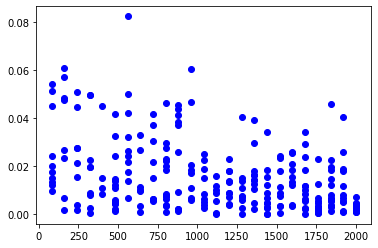

In [10]:
start_time = time.time()
Y_test_pred=model_ann.predict(X_test)
#Y_test_pred=model_ann.predict(X_test)
time_eval_ann=time.time()-start_time

real=list(list(zip(*Y_test))[0])

#real=list(map(list, zip(*Y_train)))
pred=list(Y_test_pred)

dist_min=sc_output.data_min_[0]
dist_max=sc_output.data_max_[0]

real_abs=np.add(dist_min,np.multiply((dist_max-dist_min),real))
real_abs=[int(np.round(i)) for i in real_abs]
#print(real_abs)
pred_abs=np.add(dist_min,np.multiply((dist_max-dist_min),pred))
#print(pred_abs)

error=np.divide(np.abs(np.subtract(np.array(real_abs),np.array(pred_abs))),np.array(real_abs))

res=pd.DataFrame({"dist":real_abs,"pred":pred_abs,"error":error})
res.to_csv("results_pme_supervisedFeatures.csv", header=True, index=False)
plt.plot(real_abs,error,'bo')
plt.show()

In [11]:
R=[]
for ll in distances: 
    res_mean=np.mean(res[res["dist"]==ll*80])
    res_std=np.std(res[res["dist"]==ll*80])
    R.append([res_mean["dist"],res_mean["pred"],res_std["pred"]])
R=pd.DataFrame(R)
R.columns=["dist","mean","std"]

In [12]:
R.to_csv(model_path+"/reference.csv", index=False)
json_model = model_ann.model.to_json()
open(model_path+"/model_ann_architecture.json", 'w').write(json_model)
model_ann.model.save_weights(model_path+'/model_ann_weights.h5', overwrite=True)
joblib.dump(sc_input, model_path+'/scaler_input.joblib')
joblib.dump(sc_output, model_path+'/scaler_output.joblib')

['/home/mruiz/Downloads/Symbol_to_Symbol/Symbol_to_Symbol/models/scaler_output.joblib']

In [13]:
print(sc_input.data_min_)
print(sc_input.data_max_)


[-3.03670163e+00  2.91801267e+00  3.62825730e-03 -1.49080039e-02
 -1.49080039e-02  3.50405519e-03  9.46312566e-01  9.69838145e-01
  2.86608720e-03 -1.45566088e-02 -1.45566088e-02  2.67208245e-03
 -1.02006083e+00 -1.02696373e+00  2.86323312e-03 -3.93380664e-03
 -3.93380664e-03  2.76752773e-03  9.74916202e-01 -3.01918878e+00
  3.53056890e-03 -1.12415405e-02 -1.12415405e-02  2.58932458e-03]
[-2.934883    3.00177647  0.12617059  0.0077235   0.0077235   0.12351432
  1.01944524  1.05218133  0.10524003  0.00310027  0.00310027  0.12613898
 -0.95590205 -0.96450322  0.1251427   0.02316845  0.02316845  0.10861225
  1.03517582 -2.92137809  0.09748311  0.00808647  0.00808647  0.09217364]


In [14]:
X_test

array([[0.59342509, 0.14802127, 0.58666115, ..., 0.48108441, 0.48108441,
        0.64538406],
       [0.1625552 , 0.86903784, 0.14249383, ..., 0.62875561, 0.62875561,
        0.13300783],
       [0.39142598, 0.64042674, 0.28115295, ..., 0.8538253 , 0.8538253 ,
        0.40604406],
       ...,
       [0.40526361, 0.67073265, 0.25520232, ..., 0.73025854, 0.73025854,
        0.36783772],
       [0.6329661 , 0.2709607 , 0.55737788, ..., 0.74400439, 0.74400439,
        0.63383185],
       [0.7147606 , 0.25632823, 0.5570073 , ..., 0.48990457, 0.48990457,
        0.6363471 ]])